In [ ]:
!unzip "/content/pedestrian.v1i.coco.zip" -d /content/Archive

Archive:  /content/pedestrian.v1i.coco.zip
replace /content/Archive/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import json
import os

def fix_coco_annotations(input_file, output_file):
    """
    Corrige les annotations COCO en normalisant les catégories de piétons
    et en s'assurant que tous les piétons ont le même category_id
    """

    # Charger le fichier d'annotations original
    print(f"📖 Lecture du fichier: {input_file}")
    with open(input_file, 'r') as f:
        coco_data = json.load(f)

    # Analyser la situation actuelle
    print("🔍 Analyse des catégories existantes:")
    for category in coco_data['categories']:
        print(f"   ID: {category['id']}, Nom: '{category['name']}'")

    # Créer une nouvelle liste de catégories propre
    # Dans le format COCO pour la détection, nous avons besoin de:
    # - ID 0: réservé implicitement pour l'arrière-plan (background)
    # - ID 1: notre classe d'intérêt (pedestrian)
    new_categories = [
        {
            "id": 1,
            "name": "pedestrian",
            "supercategory": "person"
        }
    ]

    # Remplacer les catégories dans les données
    coco_data['categories'] = new_categories
    print("✅ Nouvelles catégories créées:")
    for category in new_categories:
        print(f"   ID: {category['id']}, Nom: '{category['name']}'")

    # Normaliser tous les category_id dans les annotations
    # Tous les objets annotés deviennent des piétons avec category_id = 1
    annotations_modified = 0
    for annotation in coco_data['annotations']:
        if annotation['category_id'] in [0, 1]:  # Les deux IDs problématiques
            annotation['category_id'] = 1  # Normaliser vers 1 (pedestrian)
            annotations_modified += 1

    print(f"🔧 {annotations_modified} annotations mises à jour")

    # Vérifier quelques statistiques pour s'assurer que tout va bien
    total_annotations = len(coco_data['annotations'])
    total_images = len(coco_data['images'])

    print(f"📊 Résumé du dataset nettoyé:")
    print(f"   Images totales: {total_images}")
    print(f"   Annotations totales: {total_annotations}")
    print(f"   Catégories: {len(new_categories)}")

    # Sauvegarder le fichier corrigé
    print(f"💾 Sauvegarde vers: {output_file}")
    with open(output_file, 'w') as f:
        json.dump(coco_data, f, indent=2)

    return coco_data

def verify_annotations(annotation_file, num_samples=5):
    """
    Vérifie que les annotations sont correctement formatées
    en affichant quelques exemples
    """

    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)

    print(f"🔍 Vérification de {num_samples} annotations aléatoirement:")

    import random
    sample_annotations = random.sample(coco_data['annotations'],
                                     min(num_samples, len(coco_data['annotations'])))

    for i, ann in enumerate(sample_annotations, 1):
        print(f"   Exemple {i}:")
        print(f"     Image ID: {ann['image_id']}")
        print(f"     Catégorie ID: {ann['category_id']}")
        print(f"     Bbox: {ann['bbox']}")
        print(f"     Aire: {ann.get('area', 'Non spécifiée')}")

# Utilisation du script
if __name__ == "__main__":
    # Chemins des fichiers - ajustez selon votre environnement
    input_annotation_file = "/content/Archive/train/_annotations.coco.json"
    output_annotation_file = "/content/Archive/train/_annotations_fixed.coco.json"

    print("🚀 Début de la correction des annotations COCO")
    print("=" * 50)

    # Étape 1: Corriger les annotations
    try:
        fixed_data = fix_coco_annotations(input_annotation_file, output_annotation_file)
        print("=" * 50)
        print("✅ Correction terminée avec succès!")

        # Étape 2: Vérifier le résultat
        print("\n🔍 Vérification du fichier corrigé:")
        verify_annotations(output_annotation_file)

        print("\n📋 Prochaines étapes:")
        print("1. Utilisez le nouveau fichier: '_annotations_fixed.coco.json'")
        print("2. Modifiez votre code pour pointer vers ce fichier")
        print("3. Relancez l'entraînement avec les données propres")

    except FileNotFoundError:
        print("❌ Erreur: Fichier d'annotations non trouvé!")
        print("Vérifiez que le chemin est correct:")
        print(f"   Cherché: {input_annotation_file}")

    except Exception as e:
        print(f"❌ Erreur inattendue: {e}")
        print("Vérifiez le format de votre fichier JSON")

🚀 Début de la correction des annotations COCO
📖 Lecture du fichier: /content/Archive/train/_annotations.coco.json
🔍 Analyse des catégories existantes:
   ID: 0, Nom: 'pedestrian'
   ID: 1, Nom: 'pedestrian'
✅ Nouvelles catégories créées:
   ID: 1, Nom: 'pedestrian'
🔧 1368 annotations mises à jour
📊 Résumé du dataset nettoyé:
   Images totales: 304
   Annotations totales: 1368
   Catégories: 1
💾 Sauvegarde vers: /content/Archive/train/_annotations_fixed.coco.json
✅ Correction terminée avec succès!

🔍 Vérification du fichier corrigé:
🔍 Vérification de 5 annotations aléatoirement:
   Exemple 1:
     Image ID: 30
     Catégorie ID: 1
     Bbox: [38, 26, 14, 39]
     Aire: 546
   Exemple 2:
     Image ID: 166
     Catégorie ID: 1
     Bbox: [66, 30, 8, 25]
     Aire: 200
   Exemple 3:
     Image ID: 369
     Catégorie ID: 1
     Bbox: [45, 60, 19, 43]
     Aire: 817
   Exemple 4:
     Image ID: 29
     Catégorie ID: 1
     Bbox: [47, 40, 26, 33]
     Aire: 858
   Exemple 5:
     Image ID: 4

In [ ]:
import json
import os
import random
import shutil
from collections import defaultdict

def split_coco_dataset(input_annotation_file, images_dir, output_dir, train_ratio=0.8, random_seed=42):
    """
    Divise un dataset COCO en ensembles d'entraînement et de validation

    Paramètres:
    - input_annotation_file: fichier d'annotations COCO original
    - images_dir: dossier contenant toutes les images
    - output_dir: dossier de sortie pour les nouveaux ensembles
    - train_ratio: proportion des données pour l'entraînement (ex: 0.8 = 80%)
    - random_seed: graine pour la reproductibilité des résultats
    """

    # Fixer la graine aléatoire pour des résultats reproductibles
    # C'est crucial pour pouvoir reproduire exactement la même division
    random.seed(random_seed)

    print(f"🚀 Début de la division du dataset")
    print(f"📊 Ratio choisi: {train_ratio*100:.0f}% entraînement, {(1-train_ratio)*100:.0f}% validation")
    print("=" * 60)

    # Charger les annotations originales
    print(f"📖 Lecture des annotations: {input_annotation_file}")
    with open(input_annotation_file, 'r') as f:
        coco_data = json.load(f)

    # Analyser la structure actuelle du dataset
    total_images = len(coco_data['images'])
    total_annotations = len(coco_data['annotations'])

    print(f"📈 Dataset original:")
    print(f"   Images totales: {total_images}")
    print(f"   Annotations totales: {total_annotations}")
    print(f"   Moyenne annotations/image: {total_annotations/total_images:.1f}")

    # Créer la structure de dossiers pour les nouveaux ensembles
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'validation')

    # Créer les dossiers s'ils n'existent pas
    for directory in [train_dir, val_dir]:
        os.makedirs(directory, exist_ok=True)
        print(f"📁 Dossier créé/vérifié: {directory}")

    # Étape cruciale: mélanger les images de manière aléatoire
    # Cette randomisation évite les biais qui pourraient exister si les images
    # étaient organisées de manière particulière (par date, lieu, etc.)
    all_images = coco_data['images'].copy()
    random.shuffle(all_images)

    # Calculer le nombre d'images pour chaque ensemble
    num_train = int(len(all_images) * train_ratio)
    num_val = len(all_images) - num_train

    print(f"🔢 Division calculée:")
    print(f"   Entraînement: {num_train} images")
    print(f"   Validation: {num_val} images")

    # Diviser les images
    train_images = all_images[:num_train]
    val_images = all_images[num_train:]

    # Créer des dictionnaires pour mapper les IDs d'images
    # Cela nous permet de retrouver rapidement quelles annotations
    # correspondent à quelles images
    train_image_ids = {img['id'] for img in train_images}
    val_image_ids = {img['id'] for img in val_images}

    print("🔍 Séparation des annotations par ensemble...")

    # Séparer les annotations selon l'appartenance des images
    train_annotations = []
    val_annotations = []

    for annotation in coco_data['annotations']:
        if annotation['image_id'] in train_image_ids:
            train_annotations.append(annotation)
        elif annotation['image_id'] in val_image_ids:
            val_annotations.append(annotation)
        else:
            # Cette situation ne devrait jamais arriver si les données sont cohérentes
            print(f"⚠️  Attention: annotation orpheline trouvée (image_id: {annotation['image_id']})")

    print(f"📊 Annotations séparées:")
    print(f"   Entraînement: {len(train_annotations)}")
    print(f"   Validation: {len(val_annotations)}")

    # Créer les nouveaux fichiers d'annotations COCO
    # Chaque ensemble aura sa propre structure COCO complète
    train_coco = {
        'info': coco_data['info'],
        'licenses': coco_data['licenses'],
        'categories': coco_data['categories'],
        'images': train_images,
        'annotations': train_annotations
    }

    val_coco = {
        'info': coco_data['info'],
        'licenses': coco_data['licenses'],
        'categories': coco_data['categories'],
        'images': val_images,
        'annotations': val_annotations
    }

    # Sauvegarder les fichiers d'annotations
    train_ann_file = os.path.join(train_dir, '_annotations.coco.json')
    val_ann_file = os.path.join(val_dir, '_annotations.coco.json')

    print("💾 Sauvegarde des fichiers d'annotations...")
    with open(train_ann_file, 'w') as f:
        json.dump(train_coco, f, indent=2)

    with open(val_ann_file, 'w') as f:
        json.dump(val_coco, f, indent=2)

    # Copier les images dans leurs dossiers respectifs
    print("📁 Copie des images dans les nouveaux dossiers...")

    # Copier les images d'entraînement
    for img_info in train_images:
        src_path = os.path.join(images_dir, img_info['file_name'])
        dst_path = os.path.join(train_dir, img_info['file_name'])
        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)
        else:
            print(f"⚠️  Image manquante: {src_path}")

    # Copier les images de validation
    for img_info in val_images:
        src_path = os.path.join(images_dir, img_info['file_name'])
        dst_path = os.path.join(val_dir, img_info['file_name'])
        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)
        else:
            print(f"⚠️  Image manquante: {src_path}")

    print("=" * 60)
    print("✅ Division terminée avec succès!")

    # Afficher un résumé détaillé pour vérification
    print(f"📁 Structure créée:")
    print(f"   {train_dir}/")
    print(f"     ├── _annotations.coco.json ({len(train_annotations)} annotations)")
    print(f"     └── {len(train_images)} images")
    print(f"   {val_dir}/")
    print(f"     ├── _annotations.coco.json ({len(val_annotations)} annotations)")
    print(f"     └── {len(val_images)} images")

    return train_dir, val_dir

def verify_split_quality(train_ann_file, val_ann_file):
    """
    Vérifie la qualité de la division en analysant les statistiques
    de chaque ensemble pour s'assurer qu'ils sont représentatifs
    """

    print("\n🔍 Vérification de la qualité de la division...")

    # Charger les deux ensembles
    with open(train_ann_file, 'r') as f:
        train_data = json.load(f)

    with open(val_ann_file, 'r') as f:
        val_data = json.load(f)

    # Calculer les statistiques pour chaque ensemble
    def calculate_stats(coco_data, name):
        images = len(coco_data['images'])
        annotations = len(coco_data['annotations'])
        avg_ann_per_img = annotations / images if images > 0 else 0

        # Analyser la distribution des tailles d'images
        widths = [img['width'] for img in coco_data['images']]
        heights = [img['height'] for img in coco_data['images']]

        print(f"📊 Statistiques {name}:")
        print(f"   Images: {images}")
        print(f"   Annotations: {annotations}")
        print(f"   Annotations/image: {avg_ann_per_img:.2f}")
        print(f"   Taille moyenne: {sum(widths)/len(widths):.0f} x {sum(heights)/len(heights):.0f}")

        return {
            'images': images,
            'annotations': annotations,
            'avg_annotations': avg_ann_per_img
        }

    train_stats = calculate_stats(train_data, "ENTRAÎNEMENT")
    val_stats = calculate_stats(val_data, "VALIDATION")

    # Vérifier que les distributions sont similaires
    ratio_diff = abs(train_stats['avg_annotations'] - val_stats['avg_annotations'])
    if ratio_diff < 0.5:
        print("✅ Les ensembles ont des distributions similaires d'annotations")
    else:
        print("⚠️  Attention: grande différence dans la densité d'annotations entre les ensembles")

# Script principal d'exécution
if __name__ == "__main__":
    # Configuration des chemins - ajustez selon votre environnement
    input_annotation_file = "/content/Archive/train/_annotations_fixed.coco.json"  # Utilise le fichier corrigé
    images_directory = "/content/Archive/train"  # Dossier contenant toutes vos images
    output_directory = "/content/Archive/split_dataset"  # Nouveau dossier pour les ensembles divisés

    print("🎯 DIVISION DU DATASET COCO EN ENTRAÎNEMENT/VALIDATION")
    print("=" * 70)

    try:
        # Effectuer la division avec 80% pour l'entraînement, 20% pour la validation
        train_folder, val_folder = split_coco_dataset(
            input_annotation_file=input_annotation_file,
            images_dir=images_directory,
            output_dir=output_directory,
            train_ratio=0.8,  # Vous pouvez ajuster ce ratio selon vos besoins
            random_seed=42    # Assure la reproductibilité
        )

        # Vérifier la qualité de la division
        verify_split_quality(
            os.path.join(train_folder, '_annotations.coco.json'),
            os.path.join(val_folder, '_annotations.coco.json')
        )

        print("\n📋 PROCHAINES ÉTAPES:")
        print("1. Modifiez votre code d'entraînement pour utiliser:")
        print(f"   - Entraînement: {train_folder}")
        print(f"   - Validation: {val_folder}")
        print("2. Implémentez la validation pendant l'entraînement")
        print("3. Surveillez les métriques sur les deux ensembles")

    except FileNotFoundError as e:
        print(f"❌ Erreur: Fichier non trouvé - {e}")
        print("Vérifiez que tous les chemins sont corrects")

    except Exception as e:
        print(f"❌ Erreur inattendue: {e}")
        print("Vérifiez la structure de vos données et les permissions de fichiers")

🎯 DIVISION DU DATASET COCO EN ENTRAÎNEMENT/VALIDATION
🚀 Début de la division du dataset
📊 Ratio choisi: 80% entraînement, 20% validation
📖 Lecture des annotations: /content/Archive/train/_annotations_fixed.coco.json
📈 Dataset original:
   Images totales: 243
   Annotations totales: 1057
   Moyenne annotations/image: 4.3
📁 Dossier créé/vérifié: /content/Archive/split_dataset/train
📁 Dossier créé/vérifié: /content/Archive/split_dataset/validation
🔢 Division calculée:
   Entraînement: 194 images
   Validation: 49 images
🔍 Séparation des annotations par ensemble...
📊 Annotations séparées:
   Entraînement: 862
   Validation: 195
💾 Sauvegarde des fichiers d'annotations...
📁 Copie des images dans les nouveaux dossiers...
✅ Division terminée avec succès!
📁 Structure créée:
   /content/Archive/split_dataset/train/
     ├── _annotations.coco.json (862 annotations)
     └── 194 images
   /content/Archive/split_dataset/validation/
     ├── _annotations.coco.json (195 annotations)
     └── 49 image


# =====================================================
# ÉTAPE 1: Installation des dépendances
# =====================================================
# !pip install torch torchvision

In [ ]:
!pip install torch torchvision


In [ ]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# =====================================================
# ÉTAPE 2: Configuration des chemins - MODIFIÉ
# =====================================================
# Ces chemins pointent maintenant vers vos données divisées et corrigées

In [ ]:
TRAIN_ROOT = "/content/Archive/split_dataset/train"
TRAIN_ANNOTATIONS = "/content/Archive/split_dataset/train/_annotations.coco.json"
VAL_ROOT = "/content/Archive/split_dataset/validation"
VAL_ANNOTATIONS = "/content/Archive/split_dataset/validation/_annotations.coco.json"

print("📁 Configuration des chemins:")
print(f"   Entraînement: {TRAIN_ROOT}")
print(f"   Validation: {VAL_ROOT}")

📁 Configuration des chemins:
   Entraînement: /content/Archive/split_dataset/train
   Validation: /content/Archive/split_dataset/validation


# =====================================================
# ÉTAPE 3: Fonctions utilitaires améliorées
# =====================================================

In [ ]:
def convert_coco_to_torch_format(coco_targets):
    """
    Convertit les annotations COCO au format attendu par PyTorch.
    Cette fonction est cruciale car elle transforme les coordonnées
    du format COCO [x, y, width, height] vers le format PyTorch [x1, y1, x2, y2]
    """
    if len(coco_targets) == 0:
        # Si aucune annotation, retourner des tenseurs vides
        return {
            'boxes': torch.zeros((0, 4), dtype=torch.float32),
            'labels': torch.zeros((0,), dtype=torch.int64),
        }

    boxes = []
    labels = []

    for obj in coco_targets:
        # Extraction des coordonnées COCO: [x_top_left, y_top_left, width, height]
        x, y, w, h = obj['bbox']

        # Conversion vers le format PyTorch: [x1, y1, x2, y2]
        # où (x1,y1) est le coin supérieur gauche et (x2,y2) le coin inférieur droit
        x1, y1, x2, y2 = x, y, x + w, y + h
        boxes.append([x1, y1, x2, y2])

        # Récupération du label de catégorie (maintenant cohérent grâce au fix)
        labels.append(obj['category_id'])

    return {
        'boxes': torch.tensor(boxes, dtype=torch.float32),
        'labels': torch.tensor(labels, dtype=torch.int64),
    }

def collate_fn(batch):
    """
    Fonction personnalisée pour combiner plusieurs échantillons en un batch.
    Nécessaire car les images peuvent avoir différents nombres d'annotations.
    """
    images, targets = tuple(zip(*batch))

    # Convertir chaque target COCO vers le format PyTorch
    converted_targets = []
    for target in targets:
        converted_targets.append(convert_coco_to_torch_format(target))

    return list(images), converted_targets

# =====================================================
# ÉTAPE 4: Création des datasets et dataloaders - MODIFIÉ
# =====================================================

# Transformations à appliquer sur les images
# Ces transformations normalisent les images pour l'entraînement

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertit PIL Image vers tensor et normalise [0,1]
])

print("📊 Création des datasets...")

# Dataset d'entraînement
train_dataset = CocoDetection(
    root=TRAIN_ROOT,
    annFile=TRAIN_ANNOTATIONS,
    transform=transform
)

# Dataset de validation - NOUVEAU!
val_dataset = CocoDetection(
    root=VAL_ROOT,
    annFile=VAL_ANNOTATIONS,
    transform=transform
)

print(f"✅ Dataset d'entraînement: {len(train_dataset)} images")
print(f"✅ Dataset de validation: {len(val_dataset)} images")

# Création des dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=4,  # Ajustez selon votre GPU
    shuffle=True,  # Important: mélanger les données d'entraînement
    collate_fn=collate_fn,
    num_workers=2  # Parallélisation du chargement des données
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,  # Pas besoin de mélanger les données de validation
    collate_fn=collate_fn,
    num_workers=2
)


📊 Création des datasets...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
✅ Dataset d'entraînement: 194 images
✅ Dataset de validation: 49 images


# =====================================================
# ÉTAPE 5: Configuration du modèle - MODIFIÉ
# =====================================================

In [ ]:
print("🤖 Configuration du modèle Faster R-CNN...")

# Charger Faster R-CNN pré-entraîné
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# IMPORTANT: Modification du nombre de classes
# Avec vos annotations corrigées, vous avez:
# - Classe 0: background (implicite)
# - Classe 1: pedestrian
# Donc num_classes = 2 (background + pedestrian)
num_classes = 2

# Remplacer la tête de classification
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Configuration du device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print(f"✅ Modèle configuré pour {num_classes} classes sur {device}")

🤖 Configuration du modèle Faster R-CNN...
✅ Modèle configuré pour 2 classes sur cuda


# =====================================================
# ÉTAPE 6: Configuration de l'optimiseur
# =====================================================


In [ ]:
# Récupérer seulement les paramètres qui nécessitent un gradient
params = [p for p in model.parameters() if p.requires_grad]

# Optimiseur SGD avec des hyperparamètres standards pour la détection d'objets
optimizer = optim.SGD(
    params,
    lr=0.005,           # Learning rate initial
    momentum=0.9,       # Momentum pour accélérer la convergence
    weight_decay=0.0005 # Régularisation L2 pour éviter l'overfitting
)

# Scheduler pour réduire le learning rate au cours de l'entraînement
lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,  # Réduire le LR tous les 3 epochs
    gamma=0.1     # Facteur de réduction (LR = LR * 0.1)
)

# =====================================================
# ÉTAPE 7: Fonction d'entraînement améliorée - NOUVEAU!
# =====================================================


In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    """
    Entraîne le modèle pendant une époque et retourne les métriques
    """
    model.train()  # Mode entraînement
    total_loss = 0
    num_batches = 0

    print(f"🚀 Epoch {epoch + 1} - Entraînement...")

    for batch_idx, (images, targets) in enumerate(data_loader):
        # Déplacer les données vers le GPU/CPU
        images = [img.to(device) for img in images]
        targets = [
            {k: v.to(device) for k, v in target.items()}
            for target in targets
        ]

        # Forward pass - le modèle calcule automatiquement les pertes en mode train
        loss_dict = model(images, targets)

        # Calculer la perte totale
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()  # Remettre les gradients à zéro
        losses.backward()      # Calcul des gradients
        optimizer.step()       # Mise à jour des poids

        total_loss += losses.item()
        num_batches += 1

        # Affichage périodique des pertes
        if batch_idx % 10 == 0:
            print(f"   Batch {batch_idx}/{len(data_loader)}: Loss = {losses.item():.4f}")

    avg_loss = total_loss / num_batches
    print(f"✅ Epoch {epoch + 1} terminée - Perte moyenne: {avg_loss:.4f}")
    return avg_loss

def validate_model(model, data_loader, device):
    """
    Évalue le modèle sur les données de validation
    Cette fonction est cruciale pour surveiller l'overfitting
    """
    model.eval()  # Mode évaluation
    total_loss = 0
    num_batches = 0

    print("🔍 Évaluation sur les données de validation...")

    with torch.no_grad():  # Pas de calcul de gradients en validation
        for images, targets in data_loader:
            # Déplacer les données vers le device
            images = [img.to(device) for img in images]
            targets = [
                {k: v.to(device) for k, v in target.items()}
                for target in targets
            ]

            # Pour la validation, nous devons mettre le modèle en mode train
            # temporairement pour calculer les pertes
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            model.eval()  # Remettre en mode évaluation

            total_loss += losses.item()
            num_batches += 1

    avg_val_loss = total_loss / num_batches
    print(f"✅ Validation terminée - Perte moyenne: {avg_val_loss:.4f}")
    return avg_val_loss

# =====================================================
# ÉTAPE 8: Boucle d'entraînement principale - MODIFIÉE
# =====================================================


In [ ]:
def train_model(num_epochs=10):
    """
    Boucle d'entraînement principale avec validation
    """
    print("🎯 DÉBUT DE L'ENTRAÎNEMENT")
    print("=" * 50)

    # Listes pour stocker l'historique des pertes
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\n📊 EPOCH {epoch + 1}/{num_epochs}")
        print("-" * 30)

        # Entraînement
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        train_losses.append(train_loss)

        # Validation
        val_loss = validate_model(model, val_loader, device)
        val_losses.append(val_loss)

        # Mise à jour du learning rate
        lr_scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"📈 Learning rate actuel: {current_lr:.6f}")

        # Sauvegarde du meilleur modèle
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"💾 Nouveau meilleur modèle sauvegardé (val_loss: {val_loss:.4f})")

        # Détection précoce d'overfitting
        if len(val_losses) > 1 and val_loss > val_losses[-2]:
            print("⚠️  Attention: la perte de validation augmente (possibile overfitting)")

    print("\n🎉 ENTRAÎNEMENT TERMINÉ!")
    print(f"🏆 Meilleure perte de validation: {best_val_loss:.4f}")

    # Graphique des pertes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Entraînement')
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Perte')
    plt.title('Évolution des pertes pendant l\'entraînement')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses

# =====================================================
# ÉTAPE 9: Fonction de test améliorée - MODIFIÉE
# =====================================================


In [ ]:
def test_model_on_image(image_path, confidence_threshold=0.5):
    """
    Teste le modèle sur une image et affiche les résultats
    """
    print(f"🖼️  Test sur l'image: {image_path}")

    # Charger le meilleur modèle sauvegardé
    if os.path.exists('best_model.pth'):
        model.load_state_dict(torch.load('best_model.pth'))
        print("✅ Meilleur modèle chargé")

    model.eval()

    # Charger et préparer l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Erreur: impossible de charger l'image {image_path}")
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convertir en tensor
    img_tensor = torch.from_numpy(image_rgb / 255.).permute(2, 0, 1).float()
    img_tensor = img_tensor.to(device).unsqueeze(0)

    # Inférence
    with torch.no_grad():
        predictions = model(img_tensor)[0]

    # Traitement des résultats
    boxes = predictions['boxes'].cpu()
    scores = predictions['scores'].cpu()
    labels = predictions['labels'].cpu()

    print(f"🎯 {len(boxes)} détections trouvées")

    # Filtrer par confiance et dessiner
    detections_count = 0
    for box, score, label in zip(boxes, scores, labels):
        if score >= confidence_threshold:
            detections_count += 1
            x1, y1, x2, y2 = box.int().tolist()

            # Dessiner la boîte englobante
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Ajouter le texte avec la confiance
            text = f'Piéton {score:.2f}'
            cv2.putText(image_rgb, text, (x1, y1 - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    print(f"✅ {detections_count} piétons détectés avec confiance > {confidence_threshold}")

    # Afficher l'image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.title(f'Détection de piétons - {detections_count} détections')
    plt.axis('off')
    plt.show()

# =====================================================
# ÉTAPE 10: Exécution du pipeline complet
# =====================================================


🚀 DÉMARRAGE DU PIPELINE D'ENTRAÎNEMENT COMPLET
🔍 Vérification de la cohérence des données...
✅ Structure des données vérifiée

🧪 Test rapide du dataset...
   Image d'entraînement: torch.Size([3, 156, 208])
   Nombre d'annotations: 6
   Image de validation: torch.Size([3, 156, 208])
   Nombre d'annotations: 2
✅ Dataset fonctionnel

🎯 Lancement de l'entraînement...
🎯 DÉBUT DE L'ENTRAÎNEMENT

📊 EPOCH 1/5
------------------------------
🚀 Epoch 1 - Entraînement...
   Batch 0/49: Loss = 0.1783
   Batch 10/49: Loss = 0.2816
   Batch 20/49: Loss = 0.1397
   Batch 30/49: Loss = 0.1395
   Batch 40/49: Loss = 0.1782
✅ Epoch 1 terminée - Perte moyenne: 0.2010
🔍 Évaluation sur les données de validation...
✅ Validation terminée - Perte moyenne: 0.2960
📈 Learning rate actuel: 0.000050
💾 Nouveau meilleur modèle sauvegardé (val_loss: 0.2960)

📊 EPOCH 2/5
------------------------------
🚀 Epoch 2 - Entraînement...
   Batch 0/49: Loss = 0.2012
   Batch 10/49: Loss = 0.1227
   Batch 20/49: Loss = 0.2601
  

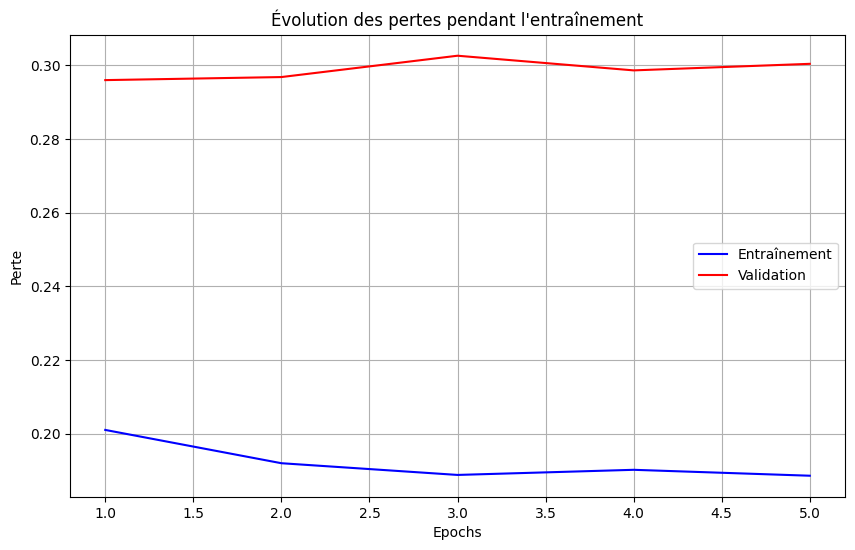


🖼️  Test du modèle entraîné...
🖼️  Test sur l'image: /content/16.jpeg
✅ Meilleur modèle chargé
🎯 12 détections trouvées
✅ 7 piétons détectés avec confiance > 0.3


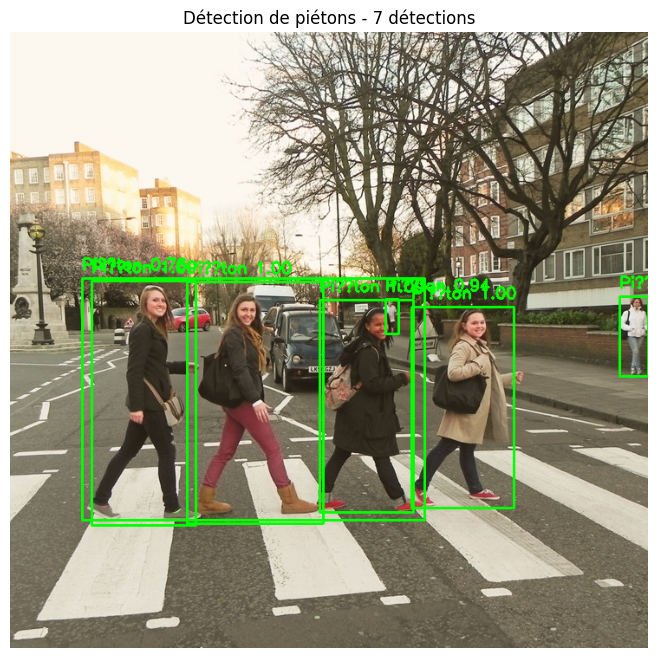


🎉 PIPELINE TERMINÉ AVEC SUCCÈS!
📋 Prochaines étapes recommandées:
   1. Augmentez le nombre d'epochs si les résultats sont encourageants
   2. Ajustez les hyperparamètres (learning rate, batch size)
   3. Testez sur plus d'images pour évaluer les performances
   4. Considérez l'augmentation de données si nécessaire


In [ ]:

if __name__ == "__main__":
    print("🚀 DÉMARRAGE DU PIPELINE D'ENTRAÎNEMENT COMPLET")
    print("=" * 60)

    # Vérification de la cohérence des données
    print("🔍 Vérification de la cohérence des données...")
    if not os.path.exists(TRAIN_ROOT):
        print("❌ Erreur: Le dossier d'entraînement n'existe pas!")
        print("   Assurez-vous d'avoir exécuté les scripts de correction et de division d'abord.")
        exit(1)

    if not os.path.exists(VAL_ROOT):
        print("❌ Erreur: Le dossier de validation n'existe pas!")
        print("   Assurez-vous d'avoir exécuté le script de division d'abord.")
        exit(1)

    print("✅ Structure des données vérifiée")

    # Test rapide du dataset
    print("\n🧪 Test rapide du dataset...")
    try:
        train_img, train_target = train_dataset[0]
        print(f"   Image d'entraînement: {train_img.shape}")
        print(f"   Nombre d'annotations: {len(train_target)}")

        val_img, val_target = val_dataset[0]
        print(f"   Image de validation: {val_img.shape}")
        print(f"   Nombre d'annotations: {len(val_target)}")
    except Exception as e:
        print(f"❌ Erreur lors du test du dataset: {e}")
        exit(1)

    print("✅ Dataset fonctionnel")

    # Lancement de l'entraînement
    print("\n🎯 Lancement de l'entraînement...")
    train_losses, val_losses = train_model(num_epochs=5)  # Commencez avec peu d'epochs

    # Test sur une image
    test_image_path = "/content/16.jpeg"  # Remplacez par votre image de test
    if os.path.exists(test_image_path):
        print(f"\n🖼️  Test du modèle entraîné...")
        test_model_on_image(test_image_path, confidence_threshold=0.3)
    else:
        print(f"⚠️  Image de test non trouvée: {test_image_path}")
        print("   Modifiez le chemin ou ajoutez une image de test")

    print("\n🎉 PIPELINE TERMINÉ AVEC SUCCÈS!")
    print("📋 Prochaines étapes recommandées:")
    print("   1. Augmentez le nombre d'epochs si les résultats sont encourageants")
    print("   2. Ajustez les hyperparamètres (learning rate, batch size)")
    print("   3. Testez sur plus d'images pour évaluer les performances")
    print("   4. Considérez l'augmentation de données si nécessaire")

🚀 DÉTECTEUR DE PIÉTONS - INTERFACE FINALE
🎯 DÉMONSTRATION DU DÉTECTEUR DE PIÉTONS
🤖 Initialisation du détecteur de piétons...
   Device utilisé: cuda
📦 Chargement du modèle depuis: best_model.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


✅ Poids du modèle chargés avec succès
✅ Détecteur initialisé et prêt à l'emploi!

📸 EXEMPLE 1: Détection sur une image
🖼️  Traitement de l'image...
🧠 Analyse par intelligence artificielle...
✅ Détection terminée en 0.17 secondes
🎯 15 piétons détectés
📊 Confiance moyenne: 0.76


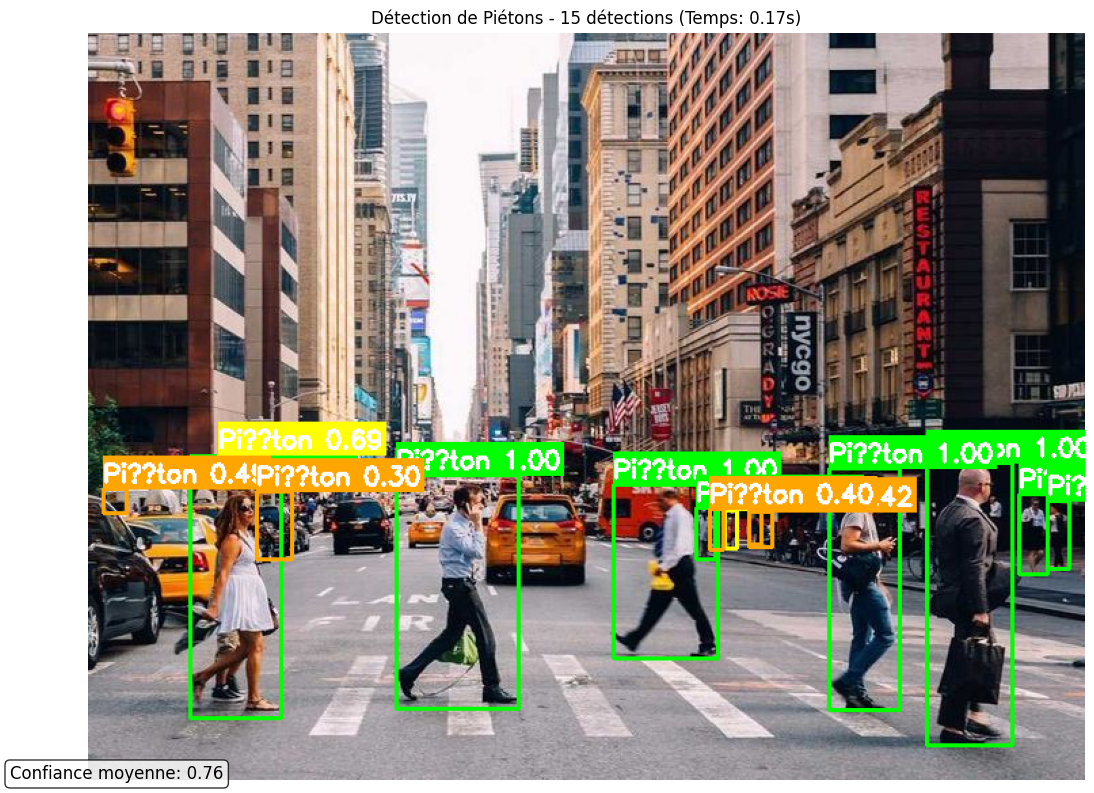

💾 Résultat sauvegardé: detection_result.jpg
Résultat: 15 piétons détectés

📁 EXEMPLE 2: Traitement en lot
⚠️  Dossier de test non trouvé: /content/test_images
   Créez un dossier avec des images pour tester le traitement en lot

🎚️  EXEMPLE 3: Test avec différents seuils
🖼️  Traitement de l'image...
🧠 Analyse par intelligence artificielle...
✅ Détection terminée en 0.14 secondes
🎯 15 piétons détectés
📊 Confiance moyenne: 0.76
   Seuil 0.3: 15 détections
🖼️  Traitement de l'image...
🧠 Analyse par intelligence artificielle...
✅ Détection terminée en 0.13 secondes
🎯 11 piétons détectés
📊 Confiance moyenne: 0.89
   Seuil 0.5: 11 détections
🖼️  Traitement de l'image...
🧠 Analyse par intelligence artificielle...
✅ Détection terminée en 0.11 secondes
🎯 9 piétons détectés
📊 Confiance moyenne: 0.96
   Seuil 0.7: 9 détections

🎉 DÉTECTEUR PRÊT À L'EMPLOI!

📋 COMMENT UTILISER LE DÉTECTEUR:
1. Pour une image unique:
   detector = PedestrianDetector()
   detector.detect_pedestrians('/chemin/vers/im

In [ ]:
# =====================================================
# ÉTAPE 11: DÉTECTEUR DE PIÉTONS - INTERFACE FINALE
# =====================================================

import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
import time
import glob
from pathlib import Path

class PedestrianDetector:
    """
    Classe complète pour la détection de piétons en temps réel.
    Cette classe encapsule tout le processus de détection dans une interface simple
    et réutilisable. Pensez à cela comme à votre "boîte à outils" finale pour
    détecter des piétons sur n'importe quelle image.
    """

    def __init__(self, model_path='best_model.pth', confidence_threshold=0.5):
        """
        Initialise le détecteur avec le modèle entraîné.

        Paramètres:
        - model_path: chemin vers votre modèle entraîné sauvegardé
        - confidence_threshold: seuil de confiance pour filtrer les détections
        """
        print("🤖 Initialisation du détecteur de piétons...")

        # Configuration du device (GPU si disponible, sinon CPU)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"   Device utilisé: {self.device}")

        # Seuil de confiance pour les détections
        self.confidence_threshold = confidence_threshold

        # Chargement du modèle
        self.model = self._load_model(model_path)

        # Préparation des transformations d'image
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])

        print("✅ Détecteur initialisé et prêt à l'emploi!")

    def _load_model(self, model_path):
        """
        Charge le modèle Faster R-CNN avec les poids entraînés.
        Cette méthode recrée exactement la même architecture que celle utilisée
        pendant l'entraînement, puis charge les poids optimisés.
        """
        print(f"📦 Chargement du modèle depuis: {model_path}")

        # Recréer l'architecture exacte du modèle d'entraînement
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

        # Modifier la tête de classification (2 classes: background + pedestrian)
        num_classes = 2
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # Charger les poids entraînés
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=self.device))
            print("✅ Poids du modèle chargés avec succès")
        else:
            print("⚠️  Attention: fichier de modèle non trouvé, utilisation du modèle pré-entraîné")
            print("   Pour de meilleurs résultats, entraînez d'abord le modèle")

        # Déplacer le modèle vers le device et le mettre en mode évaluation
        model.to(self.device)
        model.eval()

        return model

    def _preprocess_image(self, image_path_or_array):
        """
        Prépare l'image pour la détection en la redimensionnant et la normalisant.
        Cette étape est cruciale pour obtenir de bonnes performances car le modèle
        a été entraîné sur des images dans un format spécifique.
        """
        # Gestion de différents types d'entrée (chemin de fichier ou array numpy)
        if isinstance(image_path_or_array, str):
            # Cas 1: chemin vers un fichier image
            if not os.path.exists(image_path_or_array):
                raise FileNotFoundError(f"Image non trouvée: {image_path_or_array}")
            image = cv2.imread(image_path_or_array)
            if image is None:
                raise ValueError(f"Impossible de lire l'image: {image_path_or_array}")
        else:
            # Cas 2: array numpy (par exemple depuis une webcam)
            image = image_path_or_array

        # Conversion BGR vers RGB (OpenCV utilise BGR, PyTorch attend RGB)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Redimensionnement intelligent pour optimiser la vitesse sans perdre la qualité
        # Les grandes images ralentissent la détection sans forcément améliorer les résultats
        height, width = image_rgb.shape[:2]
        max_size = 1024  # Taille maximale recommandée

        if max(height, width) > max_size:
            # Calculer le facteur de redimensionnement en préservant les proportions
            scale = max_size / max(height, width)
            new_width = int(width * scale)
            new_height = int(height * scale)
            image_rgb = cv2.resize(image_rgb, (new_width, new_height))
            print(f"   Image redimensionnée: {width}x{height} → {new_width}x{new_height}")

        # Conversion en tensor PyTorch
        image_tensor = torch.from_numpy(image_rgb / 255.0).permute(2, 0, 1).float()
        image_tensor = image_tensor.to(self.device).unsqueeze(0)

        return image_rgb, image_tensor

    def detect_pedestrians(self, image_path_or_array, show_result=True, save_result=None):
        """
        Fonction principale de détection des piétons.

        Cette méthode effectue toute la chaîne de traitement:
        1. Préparation de l'image
        2. Inférence du modèle
        3. Post-traitement des résultats
        4. Visualisation et sauvegarde optionnelles

        Paramètres:
        - image_path_or_array: chemin vers l'image ou array numpy
        - show_result: afficher le résultat avec matplotlib
        - save_result: chemin pour sauvegarder l'image annotée (optionnel)

        Retourne:
        - dictionnaire avec les statistiques de détection
        """
        start_time = time.time()

        try:
            # Étape 1: Préparation de l'image
            print(f"🖼️  Traitement de l'image...")
            image_rgb, image_tensor = self._preprocess_image(image_path_or_array)

            # Étape 2: Inférence du modèle (la partie "intelligente")
            print("🧠 Analyse par intelligence artificielle...")
            with torch.no_grad():  # Désactiver le calcul des gradients pour accélérer
                predictions = self.model(image_tensor)[0]

            # Étape 3: Extraction et filtrage des résultats
            boxes = predictions['boxes'].cpu().numpy()
            scores = predictions['scores'].cpu().numpy()
            labels = predictions['labels'].cpu().numpy()

            # Filtrer les détections par confiance
            confident_detections = scores >= self.confidence_threshold
            final_boxes = boxes[confident_detections]
            final_scores = scores[confident_detections]
            final_labels = labels[confident_detections]

            # Étape 4: Annotation de l'image
            annotated_image = self._draw_detections(
                image_rgb.copy(), final_boxes, final_scores, final_labels
            )

            # Calcul du temps de traitement
            processing_time = time.time() - start_time

            # Préparation des statistiques
            detection_stats = {
                'total_detections': len(final_boxes),
                'processing_time': processing_time,
                'average_confidence': np.mean(final_scores) if len(final_scores) > 0 else 0,
                'detections': [
                    {
                        'box': box.tolist(),
                        'confidence': float(score),
                        'label': 'pedestrian'
                    }
                    for box, score in zip(final_boxes, final_scores)
                ]
            }

            # Affichage des résultats
            print(f"✅ Détection terminée en {processing_time:.2f} secondes")
            print(f"🎯 {len(final_boxes)} piétons détectés")
            if len(final_scores) > 0:
                print(f"📊 Confiance moyenne: {np.mean(final_scores):.2f}")

            # Visualisation optionnelle
            if show_result:
                self._display_result(annotated_image, detection_stats)

            # Sauvegarde optionnelle
            if save_result:
                self._save_result(annotated_image, save_result)

            return detection_stats

        except Exception as e:
            print(f"❌ Erreur pendant la détection: {e}")
            return {'error': str(e), 'total_detections': 0}

    def _draw_detections(self, image, boxes, scores, labels):
        """
        Dessine les boîtes englobantes et les scores sur l'image.
        Cette fonction transforme les coordonnées numériques en annotations visuelles.
        """
        for box, score, label in zip(boxes, scores, labels):
            # Extraction des coordonnées de la boîte englobante
            x1, y1, x2, y2 = box.astype(int)

            # Choix de la couleur selon la confiance
            # Vert pour haute confiance, jaune pour moyenne, rouge pour faible
            if score > 0.8:
                color = (0, 255, 0)    # Vert
            elif score > 0.6:
                color = (255, 255, 0)  # Jaune
            else:
                color = (255, 165, 0)  # Orange

            # Dessin de la boîte englobante
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Préparation du texte avec confiance
            text = f'Piéton {score:.2f}'
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]

            # Fond coloré pour le texte (améliore la lisibilité)
            cv2.rectangle(image, (x1, y1 - text_size[1] - 10),
                         (x1 + text_size[0], y1), color, -1)

            # Texte blanc sur fond coloré
            cv2.putText(image, text, (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        return image

    def _display_result(self, image, stats):
        """
        Affiche l'image avec les détections dans une fenêtre matplotlib.
        """
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        plt.title(f'Détection de Piétons - {stats["total_detections"]} détections '
                 f'(Temps: {stats["processing_time"]:.2f}s)')
        plt.axis('off')

        # Ajout d'informations textuelles
        if stats['total_detections'] > 0:
            info_text = f"Confiance moyenne: {stats['average_confidence']:.2f}"
            plt.figtext(0.02, 0.02, info_text, fontsize=12,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

        plt.tight_layout()
        plt.show()

    def _save_result(self, image, save_path):
        """
        Sauvegarde l'image annotée sur le disque.
        """
        # Conversion RGB vers BGR pour OpenCV
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        success = cv2.imwrite(save_path, image_bgr)

        if success:
            print(f"💾 Résultat sauvegardé: {save_path}")
        else:
            print(f"❌ Erreur lors de la sauvegarde: {save_path}")

    def batch_detect(self, image_folder, output_folder=None, extensions=('jpg', 'jpeg', 'png', 'bmp')):
        """
        Traite un dossier entier d'images en lot.
        Très utile pour analyser de grandes quantités d'images rapidement.
        """
        print(f"📁 Traitement en lot du dossier: {image_folder}")

        # Recherche de toutes les images dans le dossier
        image_files = []
        for ext in extensions:
            pattern = os.path.join(image_folder, f"*.{ext}")
            image_files.extend(glob.glob(pattern))
            pattern = os.path.join(image_folder, f"*.{ext.upper()}")
            image_files.extend(glob.glob(pattern))

        if not image_files:
            print("❌ Aucune image trouvée dans le dossier")
            return

        print(f"📊 {len(image_files)} images trouvées")

        # Créer le dossier de sortie si nécessaire
        if output_folder:
            os.makedirs(output_folder, exist_ok=True)

        # Statistiques globales
        total_detections = 0
        total_time = 0
        results = []

        # Traitement de chaque image
        for i, image_path in enumerate(image_files, 1):
            print(f"\n🖼️  [{i}/{len(image_files)}] {os.path.basename(image_path)}")

            # Préparation du chemin de sauvegarde
            save_path = None
            if output_folder:
                filename = Path(image_path).stem + '_detected' + Path(image_path).suffix
                save_path = os.path.join(output_folder, filename)

            # Détection (sans affichage pour le traitement en lot)
            stats = self.detect_pedestrians(
                image_path,
                show_result=False,
                save_result=save_path
            )

            # Accumulation des statistiques
            if 'error' not in stats:
                total_detections += stats['total_detections']
                total_time += stats['processing_time']
                results.append({
                    'file': os.path.basename(image_path),
                    'detections': stats['total_detections'],
                    'time': stats['processing_time']
                })

        # Résumé final
        print("\n" + "="*50)
        print("📊 RÉSUMÉ DU TRAITEMENT EN LOT")
        print("="*50)
        print(f"Images traitées: {len(results)}")
        print(f"Détections totales: {total_detections}")
        print(f"Temps total: {total_time:.2f} secondes")
        print(f"Temps moyen par image: {total_time/len(results):.2f} secondes")
        print(f"Détections moyennes par image: {total_detections/len(results):.1f}")

        return results

# =====================================================
# FONCTIONS UTILITAIRES POUR USAGE FACILE
# =====================================================

def detect_single_image(image_path, model_path='best_model.pth', confidence=0.5):
    """
    Fonction simple pour détecter les piétons sur une seule image.
    Parfait pour des tests rapides.
    """
    detector = PedestrianDetector(model_path, confidence)
    return detector.detect_pedestrians(image_path)

def detect_folder(input_folder, output_folder, model_path='best_model.pth', confidence=0.5):
    """
    Fonction simple pour traiter un dossier entier d'images.
    """
    detector = PedestrianDetector(model_path, confidence)
    return detector.batch_detect(input_folder, output_folder)

# =====================================================
# DÉMONSTRATION ET EXEMPLES D'UTILISATION
# =====================================================

def demo_detection():
    """
    Fonction de démonstration qui montre comment utiliser le détecteur
    dans différents scénarios d'usage.
    """
    print("🎯 DÉMONSTRATION DU DÉTECTEUR DE PIÉTONS")
    print("="*50)

    # Initialisation du détecteur
    detector = PedestrianDetector(
        model_path='best_model.pth',
        confidence_threshold=0.3  # Seuil assez bas pour capturer plus de détections
    )

    # Exemple 1: Détection sur une image spécifique
    print("\n📸 EXEMPLE 1: Détection sur une image")
    test_image = "/content/4.jpeg"  # Remplacez par votre image

    if os.path.exists(test_image):
        stats = detector.detect_pedestrians(
            test_image,
            show_result=True,
            save_result="detection_result.jpg"
        )
        print(f"Résultat: {stats['total_detections']} piétons détectés")
    else:
        print(f"⚠️  Image de test non trouvée: {test_image}")

    # Exemple 2: Traitement en lot (si vous avez un dossier d'images)
    print("\n📁 EXEMPLE 2: Traitement en lot")
    test_folder = "/content/test_images"  # Dossier avec plusieurs images
    output_folder = "/content/results"

    if os.path.exists(test_folder):
        results = detector.batch_detect(test_folder, output_folder)
        print(f"Traitement terminé: {len(results)} images analysées")
    else:
        print(f"⚠️  Dossier de test non trouvé: {test_folder}")
        print("   Créez un dossier avec des images pour tester le traitement en lot")

    # Exemple 3: Utilisation avec différents seuils de confiance
    print("\n🎚️  EXEMPLE 3: Test avec différents seuils")
    if os.path.exists(test_image):
        for threshold in [0.3, 0.5, 0.7]:
            detector.confidence_threshold = threshold
            stats = detector.detect_pedestrians(test_image, show_result=False)
            print(f"   Seuil {threshold}: {stats['total_detections']} détections")

# =====================================================
# SCRIPT PRINCIPAL
# =====================================================

if __name__ == "__main__":
    print("🚀 DÉTECTEUR DE PIÉTONS - INTERFACE FINALE")
    print("="*60)

    # Vérification de la présence du modèle entraîné
    model_file = 'best_model.pth'
    if not os.path.exists(model_file):
        print("⚠️  ATTENTION: Modèle entraîné non trouvé!")
        print(f"   Cherché: {model_file}")
        print("   Assurez-vous d'avoir terminé l'entraînement (ÉTAPE 10) avant d'utiliser ce détecteur")
        print("   Le détecteur utilisera le modèle pré-entraîné par défaut (moins précis)")
        print()

    # Lancement de la démonstration
    demo_detection()

    print("\n🎉 DÉTECTEUR PRÊT À L'EMPLOI!")
    print("\n📋 COMMENT UTILISER LE DÉTECTEUR:")
    print("="*40)
    print("1. Pour une image unique:")
    print("   detector = PedestrianDetector()")
    print("   detector.detect_pedestrians('/chemin/vers/image.jpg')")
    print()
    print("2. Pour un dossier d'images:")
    print("   detector.batch_detect('/dossier/images', '/dossier/resultats')")
    print()
    print("3. Fonction simple:")
    print("   detect_single_image('/chemin/vers/image.jpg')")
    print()
    print("💡 CONSEILS D'OPTIMISATION:")
    print("- Ajustez confidence_threshold selon vos besoins (0.3-0.8)")
    print("- Images plus petites = détection plus rapide")
    print("- GPU recommandé pour le traitement en lot")
    print("- Testez différents seuils pour trouver l'équilibre optimal")

🤖 Initialisation du détecteur de piétons...
   Device utilisé: cuda
📦 Chargement du modèle depuis: best_model.pth
✅ Poids du modèle chargés avec succès
✅ Détecteur initialisé et prêt à l'emploi!
🖼️  Traitement de l'image...
   Image redimensionnée: 1600x720 → 1024x460
🧠 Analyse par intelligence artificielle...
✅ Détection terminée en 0.16 secondes
🎯 7 piétons détectés
📊 Confiance moyenne: 0.79


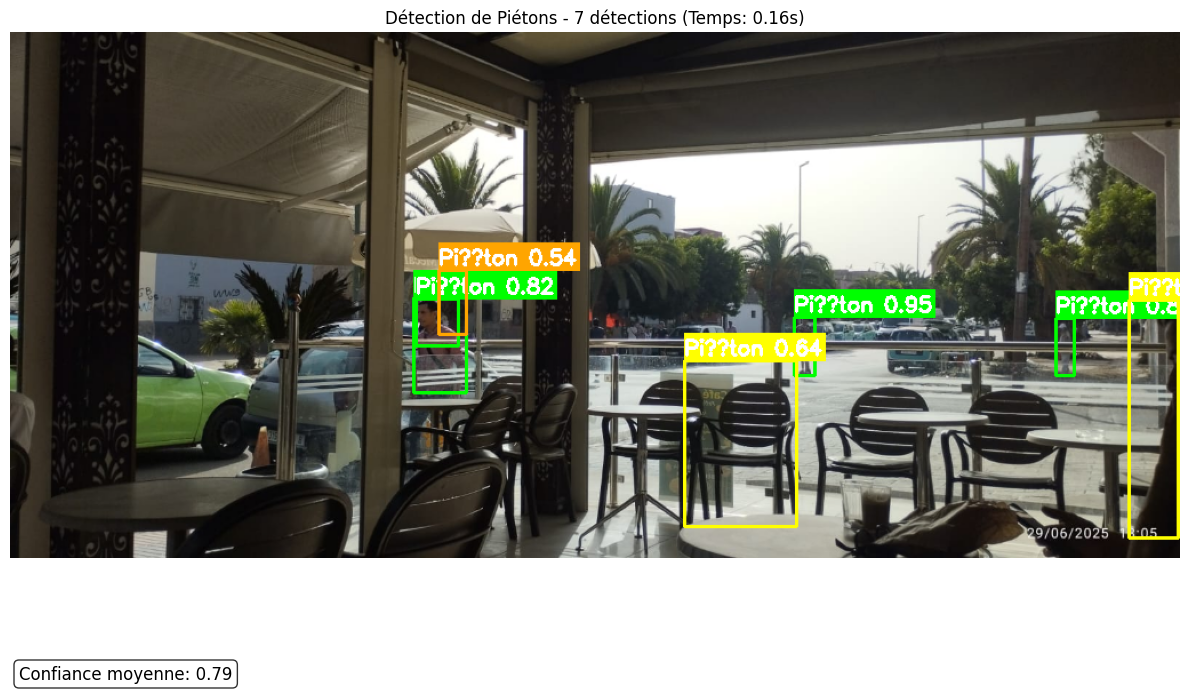

{'total_detections': 7,
 'processing_time': 0.15954327583312988,
 'average_confidence': np.float32(0.79363745),
 'detections': [{'box': [353.5378723144531,
    232.7527313232422,
    399.8656311035156,
    315.9068603515625],
   'confidence': 0.9733065366744995,
   'label': 'pedestrian'},
  {'box': [686.906494140625,
    249.66590881347656,
    704.3077392578125,
    300.3387451171875],
   'confidence': 0.9498430490493774,
   'label': 'pedestrian'},
  {'box': [915.8396606445312,
    250.5395050048828,
    931.0078735351562,
    300.26739501953125],
   'confidence': 0.8277999758720398,
   'label': 'pedestrian'},
  {'box': [355.2463073730469,
    233.60079956054688,
    392.7266845703125,
    274.93511962890625],
   'confidence': 0.8248258829116821,
   'label': 'pedestrian'},
  {'box': [979.5513916015625,
    234.75379943847656,
    1022.2496337890625,
    442.903076171875],
   'confidence': 0.7908639907836914,
   'label': 'pedestrian'},
  {'box': [590.1441040039062,
    287.360412597656

In [ ]:
detect_single_image('/content/Monastir.jpeg')

In [ ]:
from google.colab import files
files.download('best_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>